# Capstone Modeling- Jessica Williams

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge,LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from sb_utils import save_file


First let’s import the data. I will be using two different train test splits for my data. The first train test split will use the rating mean of recipes column of the data as the target variable(y). The second train test split will use the polarity average of the reviews column as the target variable.

In [2]:
recipe_attributes_p = pd.read_csv('C:/Users/jwatki8/Downloads/My Capstone project/recipe_attributes_p.csv')

In [3]:
recipe_attributes_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231634 entries, 0 to 231633
Data columns (total 59 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   recipe_id                   231634 non-null  int64  
 1   minutes                     231634 non-null  int64  
 2   n_steps                     231634 non-null  float64
 3   n_ingredients               231634 non-null  float64
 4   rating_mean                 231634 non-null  float64
 5   review_count                231634 non-null  int64  
 6   polarity_avg                231634 non-null  float64
 7   ingr_baking powder          231634 non-null  int64  
 8   ingr_baking soda            231634 non-null  int64  
 9   ingr_black pepper           231634 non-null  int64  
 10  ingr_brown sugar            231634 non-null  int64  
 11  ingr_cheddar cheese         231634 non-null  int64  
 12  ingr_cream cheese           231634 non-null  int64  
 13  ingr_garlic cl

In [4]:
len(recipe_attributes_p) * .7, len(recipe_attributes_p) * .3

(162143.8, 69490.2)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(recipe_attributes_p.drop(columns='rating_mean'), 
                                                    recipe_attributes_p.rating_mean, test_size=0.3, 
                                                    random_state=22)

In [6]:
X_train.shape, X_test.shape

((162143, 58), (69491, 58))

In [7]:
y_train.shape, y_test.shape

((162143,), (69491,))

In [8]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(recipe_attributes_p.drop(columns='polarity_avg'), 
                                                    recipe_attributes_p.polarity_avg, test_size=0.3, 
                                                    random_state=22)

In [9]:
X_train2.shape, X_test2.shape

((162143, 58), (69491, 58))

In [10]:
y_train2.shape, y_test2.shape

((162143,), (69491,))

In [11]:
id_vars = ['recipe_id']
id_train = X_train[id_vars]
id_test = X_test[id_vars]
X_train.drop(columns=id_vars, inplace=True)
X_test.drop(columns=id_vars, inplace=True)
X_train.shape, X_test.shape

((162143, 57), (69491, 57))

In [12]:
id_vars = ['recipe_id']
id_train = X_train2[id_vars]
id_test = X_test2[id_vars]
X_train2.drop(columns=id_vars, inplace=True)
X_test2.drop(columns=id_vars, inplace=True)
X_train2.shape, X_test2.shape

((162143, 57), (69491, 57))

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
scaler = StandardScaler()
scaler.fit(X_train2)
X_train2_scaled = scaler.transform(X_train2)
X_test2_scaled = scaler.transform(X_test2)

Now that we have the train test split imported, let’s experiment with a few models. First I will apply a linear regression model to the data.

## Linear Regression

In [15]:
lr = LinearRegression().fit(X_train_scaled, y_train)

In [16]:
lr_y_tr_pred = lr.predict(X_train_scaled)
lr_y_te_pred = lr.predict(X_test_scaled)

In [17]:
r2_score(y_train, lr_y_tr_pred), r2_score(y_test, lr_y_te_pred)

(0.06958851821260514, 0.06378735916930367)

In [18]:
mean_absolute_error(y_train, lr_y_tr_pred), mean_absolute_error(y_test, lr_y_te_pred)

(0.6466426445454803, 0.6420365805554163)

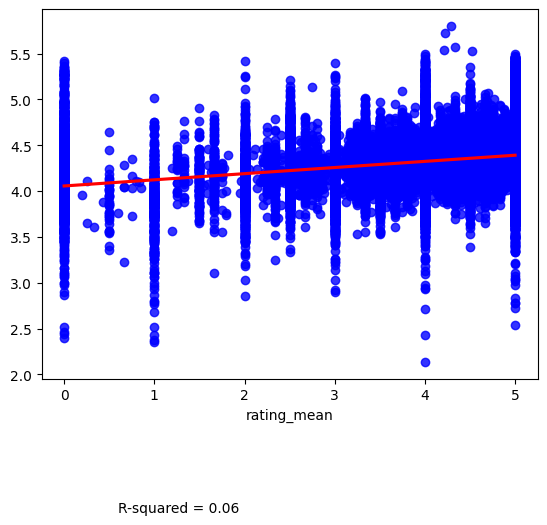

In [19]:
r_squared = 0.064
sns.regplot(x=y_test,y=lr_y_te_pred,ci=None,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.text(0.6, 0.5, 'R-squared = %0.2f' % r_squared)
plt.show()

Looking at the $R^2$ score we can see that very little variance is explained by the linear regression model. We can also see that we get a mean absolute error that is on the higher side if we consider the fact that our target variable value range is 0-5. Let’s take a look at how this model performs on train test set 2.

In [20]:
lr = LinearRegression().fit(X_train2_scaled, y_train2)

In [21]:
lr_y_tr_pred2 = lr.predict(X_train2_scaled)
lr_y_te_pred2 = lr.predict(X_test2_scaled)

In [22]:
r2_score(y_train2, lr_y_tr_pred2), r2_score(y_test2, lr_y_te_pred2)

(0.06835631102931283, 0.06364306918429008)

In [23]:
mean_absolute_error(y_train2, lr_y_tr_pred2), mean_absolute_error(y_test2, lr_y_te_pred2)

(0.12140068348072551, 0.12121129952077533)

The $R^2$ score for the model is pretty much the same as it was for the other train test set. The mae is lower but we have to consider that the value range for the review polarity average is between -1 and 1.

## Random Forest Regression

Next we will apply a random forest regression model to the data.

In [24]:
rfr = RandomForestRegressor(max_depth=2, random_state=22).fit(X_train_scaled, y_train)

In [25]:
rf_y_tr_pred = rfr.predict(X_train_scaled)
rf_y_te_pred = rfr.predict(X_test_scaled)

In [26]:
r2_score(y_train, rf_y_tr_pred), r2_score(y_test, rf_y_te_pred)

(0.09317363192864037, 0.08816164176612407)

In [27]:
mean_absolute_error(y_train, rf_y_tr_pred), mean_absolute_error(y_test, rf_y_te_pred)

(0.6472676562558916, 0.6428395361573302)

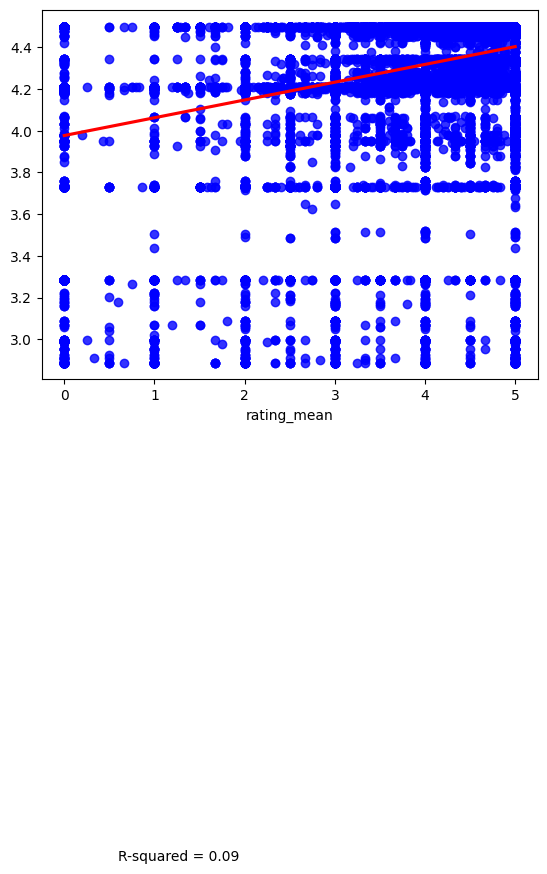

In [28]:
r_squared = 0.0881
sns.regplot(x=y_test,y=rf_y_te_pred,ci=None,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.text(0.6, 0.5, 'R-squared = %0.2f' % r_squared)
plt.show()

It looks like the $R^2$  score for this model is higher than the linear regression model, but the mean absolute error is pretty much the same. Let’s test it on our second train test set.

In [29]:
rfr = RandomForestRegressor(max_depth=2,random_state=22).fit(X_train2_scaled, y_train2)

In [30]:
rf_y_tr_pred2 = rfr.predict(X_train2_scaled)
rf_y_te_pred2 = rfr.predict(X_test2_scaled)

In [31]:
r2_score(y_train2, rf_y_tr_pred2), r2_score(y_test2, rf_y_te_pred2)

(0.06900957511660455, 0.06662175203110088)

In [32]:
mean_absolute_error(y_train2, rf_y_tr_pred2), mean_absolute_error(y_test2, rf_y_te_pred2)

(0.1216759506940545, 0.12129199693134092)

This model seems to have the same effect on this data set. Slightly larger $R^2$  score and a mean absolute error that is pretty much the same as the linear regression model.

## K-Neighbors Regression

I would also like to apply a K-Neighbors Regression model to the data.

In [33]:
knn = KNeighborsRegressor(p=2,weights='distance',n_neighbors=50)

In [34]:
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(n_neighbors=50, weights='distance')

In [35]:
kn_y_tr_pred = knn.predict(X_train_scaled)
kn_y_te_pred = knn.predict(X_test_scaled)

In [36]:
r2_score(y_test, kn_y_te_pred)

0.028905494692232914

In [37]:
mean_absolute_error(y_test, kn_y_te_pred)

0.6566240946791971

In [38]:
knn.fit(X_train2_scaled, y_train2)

KNeighborsRegressor(n_neighbors=50, weights='distance')

In [39]:
kn_y_tr_pred2 = knn.predict(X_train2_scaled)
kn_y_te_pred2 = knn.predict(X_test2_scaled)

In [40]:
r2_score(y_test2, kn_y_te_pred2)

0.012356559780633214

In [41]:
mean_absolute_error(y_test2, kn_y_te_pred2)

0.1254517719251689

From the evaluation metrics we have here we can see that this model preformed much worse than both the linear and random forest regression models. The $R^2$  score is much lower while the mae is about the same when applying this model to the first and second train test sets.

Text(0, 0.5, 'R2 score')

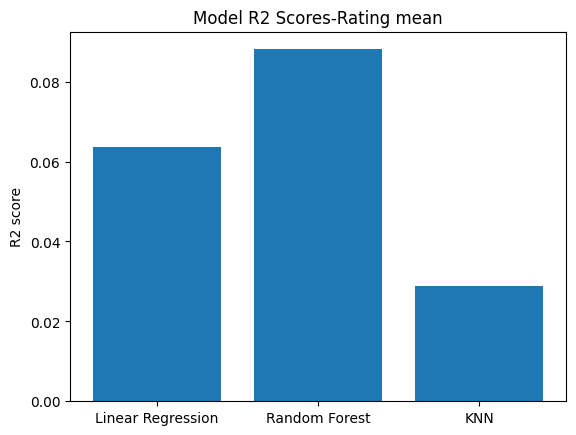

In [42]:
plt.title('Model R2 Scores-Rating mean')

plt.bar(['Linear Regression','Random Forest','KNN'], [0.0637,0.0881,0.0289])
plt.ylabel('R2 score')

Text(0, 0.5, 'R2 score')

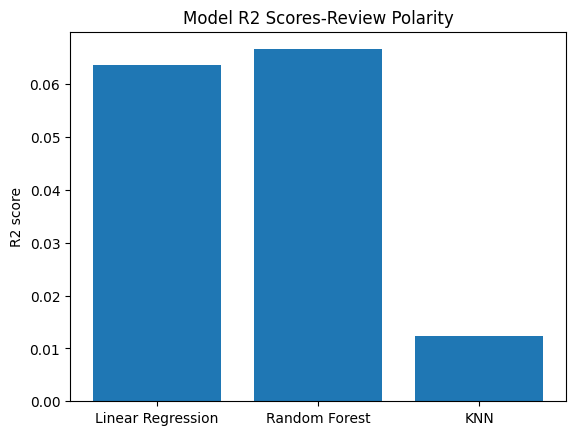

In [43]:
plt.title('Model R2 Scores-Review Polarity')

plt.bar(['Linear Regression','Random Forest','KNN'], [0.0636,0.0666,0.0123])
plt.ylabel('R2 score')

After applying a Linear regression, Random forest regression and K-Neighbors Regression, it seems that we get the best evaluation metrics with the Random forest regression model. 

## Hyperparameters

Let’s tweak the parameters and see if we can improve the model.

Because we have a very large data set I would like to run a RandomizedSearchCV for the hyperparameters individually. I will start with the max_features parameter. 

In [44]:
model = RandomForestRegressor(max_depth=2,random_state=22, n_jobs=-1) 
rs_params = {
     "max_features" : [10, 20, 30,40,50]
}

In [45]:
rf_rs_cv = RandomizedSearchCV(estimator=model, param_distributions=rs_params, n_jobs=-1)

In [46]:
rf_rs_cv.fit(X_train_scaled, y_train)

C:\Users\jwatki8\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestRegressor(max_depth=2, n_jobs=-1,
                                                   random_state=22),
                   n_jobs=-1,
                   param_distributions={'max_features': [10, 20, 30, 40, 50]})

In [47]:
rf_rs_cv.best_params_
#print(best_parameters)

{'max_features': 50}

It looks like the best number of features to consider is 50. Let’s move on to the n_estimators parameter.

In [48]:
model = RandomForestRegressor(max_depth=2,random_state=22, n_jobs=-1) 
rs_params = {
    "n_estimators" : [100,200,300,400], "max_features" : [50]
}

In [49]:
rf_rs_cv = RandomizedSearchCV(estimator=model, param_distributions=rs_params, n_jobs=-1)

In [50]:
rf_rs_cv.fit(X_train_scaled, y_train)

C:\Users\jwatki8\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestRegressor(max_depth=2, n_jobs=-1,
                                                   random_state=22),
                   n_jobs=-1,
                   param_distributions={'max_features': [50],
                                        'n_estimators': [100, 200, 300, 400]})

In [51]:
rf_rs_cv.best_params_


{'n_estimators': 300, 'max_features': 50}

We can see here that 300 trees would work best. Now lets run through a few max_depth iterations.

In [52]:
model = RandomForestRegressor(random_state=22, n_jobs=-1) 
rs_params = {
     "max_features" : [50],"n_estimators" : [300], "max_depth" : [2, 4, 6, 8]    
}

In [53]:
rf_rs_cv = RandomizedSearchCV(estimator=model, param_distributions=rs_params, n_jobs=-1)

In [54]:
rf_rs_cv.fit(X_train_scaled, y_train)

C:\Users\jwatki8\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=22),
                   n_jobs=-1,
                   param_distributions={'max_depth': [2, 4, 6, 8],
                                        'max_features': [50],
                                        'n_estimators': [300]})

In [55]:
rf_rs_cv.best_params_

{'n_estimators': 300, 'max_features': 50, 'max_depth': 8}

The max_depth of 8 is our best parameter value.

Now that I have a some new hyperparameter values, let’s apply the model to both of the train test sets.

In [56]:
rfr2 = RandomForestRegressor(max_depth=8,n_estimators=300, max_features=50, random_state=22).fit(X_train_scaled, y_train)

In [57]:
y_tr_pred = rfr2.predict(X_train_scaled)
y_te_pred = rfr2.predict(X_test_scaled)

In [58]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.1341797351145646, 0.10488857478490299)

In [59]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.6322879544593384, 0.6342450896901101)

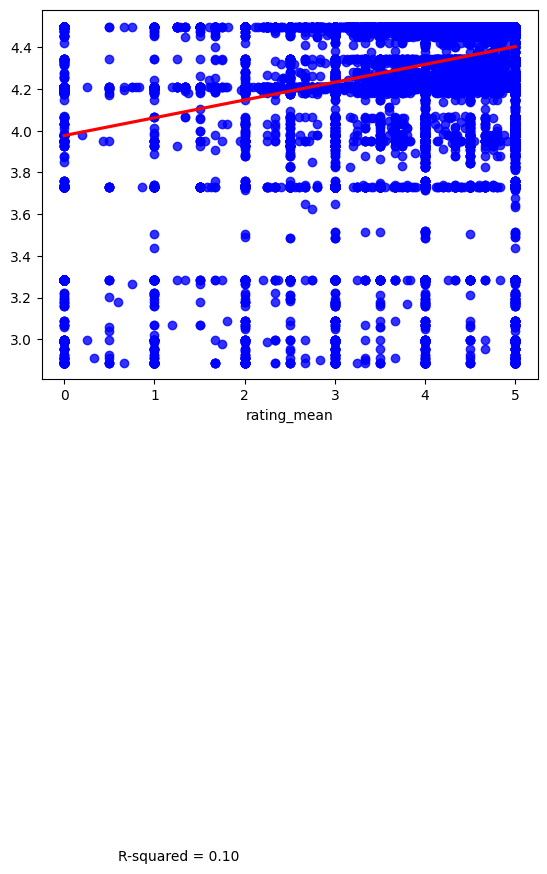

In [67]:
r_squared = 0.1048
sns.regplot(x=y_test,y=rf_y_te_pred,ci=None,scatter_kws={"color": "blue"}, line_kws={"color": "red"})
plt.text(0.6, 0.5, 'R-squared = %0.2f' % r_squared)
plt.show()

In [61]:
rfr3 = RandomForestRegressor(max_depth=8,n_estimators=300, max_features=50, random_state=22).fit(X_train2_scaled, y_train2)

In [62]:
y_tr_pred2 = rfr3.predict(X_train2_scaled)
y_te_pred2 = rfr3.predict(X_test2_scaled)

In [63]:
r2_score(y_train2, y_tr_pred2), r2_score(y_test2, y_te_pred2)

(0.10764744605089172, 0.08916027769725521)

In [64]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(0.6322879544593384, 0.6342450896901101)

I would also like to take a look at the feature importances for the model on both datasets.

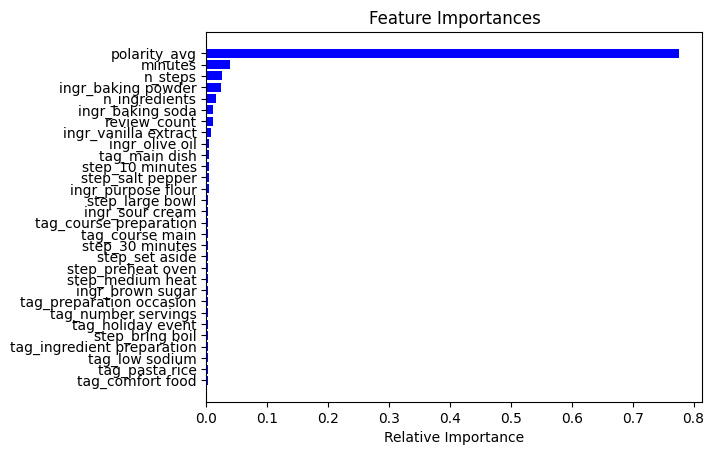

In [65]:
importances = rfr2.feature_importances_

indices = np.argsort(importances)[-30:] 

fig, ax = plt.subplots()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlabel('Relative Importance')
ax.set_yticks(range(len(indices)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

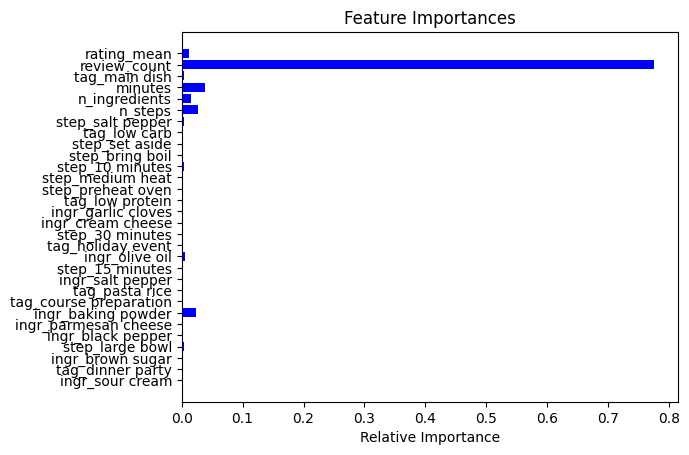

In [66]:
importances3 = rfr3.feature_importances_

indices3 = np.argsort(importances3)[-30:] 

fig, ax = plt.subplots()
plt.title('Feature Importances')
plt.barh(range(len(indices3)), importances[indices3], color='b', align='center')
plt.xlabel('Relative Importance')
ax.set_yticks(range(len(indices3)))
_ = ax.set_yticklabels(np.array(X_train2.columns)[indices3])

## Conclusion

From looking at the feature importances for both datasets, we can see that the standouts are the variables that could be considered a part of the target variable as well such as review polarity and review count. Both of these are essentially measures of user engagement. Following far behind these features are the minutes feature, number of ingredients feature and the number of steps feature. These sit in the top 5 for importance for each train test set. We can also see a few intersections in the top 30 features for both sets with step text features(step_10 minutes, step_30 minutes) and ingredient text features(ingr_baking powder, ingr_baking soda). This suggests that the amount of time a recipe takes could be an important influencer of user satisfaction and engagement.

Although running the model using these hyperparameters gives us the best $R^2$  scores we’ve seen thus far along with a comparable mae to the other model iterations, our features still don’t give us a lot of predictive power. Also, it does seem that overall the model performs better on our rating mean target variable than it does our review polarity variable.  

Our $R^2$  for the train and test sets are 0.134 and 0.105. 

Our mean absolute error for the train and test sets are 0.632 and 0.634.